In [181]:
#parameters
survey_type = "nat"
generation = "llama_propbanksenses"

if survey_type == "nat" and generation == "llama_llamasenses":
  mean_file_name = "nat_mean_llama_llamasenses.csv"
  longform_file_name = "naturalness_llama_llamasenses_longform.csv"

  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/02_16_24/naturalness_llama_llamasenses_raw_021324.csv'

elif survey_type == "nat" and generation == "llama_propbanksenses":
  mean_file_name = "nat_mean_llama_propbanksenses.csv"
  longform_file_name = "naturalness_llama_propbanksenses_longform.csv"

  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/02_02_24/naturalness_llama_propbanksense_012824.csv'

elif survey_type == "nat": # for corpus sentences
  mean_file_name = "nat_mean_reddit.csv"
  longform_file_name = "naturalness_reddit_longform.csv"
  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/final_data/nat/raw_nat_reddit.csv'

elif survey_type == "typ" and generation == "llama_llamasenses":
  mean_file_name = "typ_mean_llama_llamasenses.csv"
  longform_file_name = "typicality_llama_llamasenses_longform.csv"

  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/02_16_24/typicality_llama_llamasenses_raw_021324.csv'

elif survey_type == "typ" and generation == "llama_propbanksenses":
  mean_file_name = "typ_mean_llama_propbanksenses.csv"
  longform_file_name = "typicality_llama_propbanksenses_longform.csv"

  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/02_02_24/typicality_llama_propbanksense_raw_012924.csv'

elif survey_type == "typ": # for corpus sentences
  mean_file_name = "typ_mean_reddit.csv"
  longform_file_name = "typicality_reddit_longform.csv"

  raw_path = '/content/drive/MyDrive/projects/2023/glass_project/final_data/typ/raw_typ_reddit.csv'
else:
  print("There is something wrong.")

# print(raw_path)


In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
# import os
# os.chdir('/content/drive/MyDrive/projects/2023/glass_project')

In [184]:
import pandas as pd
import numpy as np
import spacy
import statistics
import matplotlib.pyplot as plt
from scipy.stats import zscore

!pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.nn import functional as F
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

Load raw data

In [185]:
def load_raw_data(path):
  df = pd.read_csv(path)
  df = df.drop(columns=['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
                      'RecordedDate', 'RecipientLastName', 'RecipientFirstName',
                      'RecipientEmail', 'ExternalReference', 'LocationLatitude',
                      'LocationLongitude', 'DistributionChannel', 'UserLanguage'])
  return df

#!!!
# path = '/content/drive/MyDrive/projects/2023/glass_project/02_02_24/naturalness_llama_propbanksense_012824.csv'
# path = '/content/drive/MyDrive/projects/2023/glass_project/02_02_24/naturalness_llama_llamasenses_raw_020124.csv'
# path = '/content/drive/MyDrive/projects/2023/glass_project/final_data/nat/raw_nat_reddit.csv'

# df = pd.read_csv(path)
# df = df.drop(columns=['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
                      # 'RecordedDate', 'RecipientLastName', 'RecipientFirstName',
                      # 'RecipientEmail', 'ExternalReference', 'LocationLatitude',
                      # 'LocationLongitude', 'DistributionChannel', 'UserLanguage'])

df = load_raw_data(raw_path)

Load sentences

In [186]:
def load_sentences(generation):
  if generation == "llama_llamasenses":
    path_llama = '/content/drive/MyDrive/projects/2023/glass_project/01_19_24/llama_llamasenses_generation_top_four_surp.csv'
  elif generation == "llama_propbanksenses":
    path_llama = '/content/drive/MyDrive/projects/2023/glass_project/01_26_24/llama_propbanksenses_generation_top_four_surp.csv'
  else: #for generation==corpus
    path_llama = '/content/drive/MyDrive/projects/2023/glass_project/02_16_24/reddit_sents_with_originals_surp.csv'

  df_llama = pd.read_csv(path_llama)

  if generation == "reddit":
    llama_sents = list(df_llama['constructed_sent'])
    llama_sents_with_senses = list(zip(df_llama['constructed_sent'], df_llama['sense'], df_llama['sense_descr'], df_llama['verb_lemma'], df_llama['post_comment_id'], df_llama['surprisal_4']))
    df_llama = df_llama.rename(columns={'constructed_sent': 'sentence', 'sense': 'sense_id', 'sense_descr': 'sense', 'surprisal_4': 'surprisal'})
    try:
      df_llama = df_llama.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
    except:
      pass

  else:
    llama_sents = list(df_llama['sentence'])
    llama_sents_with_senses = list(zip(df_llama['sentence'], df_llama['sense_id'], df_llama['sense'], df_llama['verb'], df_llama['sentence_id'], df_llama['surprisal_4']))
  return llama_sents_with_senses, df_llama

llama_sents_with_senses = load_sentences(generation)[0]
df_llama = load_sentences(generation)[1]

In [187]:
df_llama

,Unnamed: 0,verb,sense_id,sense,sentence_id,sentence,seed,surprisal_1,temp,surprisal_4,surprisal_3,surprisal_2
0,0,abuse,abuse.01,"mistreat a person or animal, often repeatedly,...",abuse.01_1,The man abused the dog.,43.0,25.729469,0.8,130.050201,32.679214,29.924370
1,1,abuse,abuse.01,"mistreat a person or animal, often repeatedly,...",abuse.01_2,The man abused the cat.,44.0,26.827587,0.8,143.452347,33.715408,31.203403
2,2,abuse,abuse.01,"mistreat a person or animal, often repeatedly,...",abuse.01_7,The children abused the dog.,49.0,27.017658,0.8,151.097351,33.471828,55.525871
3,3,abuse,abuse.01,"mistreat a person or animal, often repeatedly,...",abuse.01_0,The man abused the horse.,42.0,27.438953,0.8,158.528000,34.996765,32.178364
4,4,abuse,abuse.02,use (something) to bad effect or for a bad pur...,abuse.02_8,The government abused the power.,50.0,29.510235,0.8,137.599884,38.242912,34.846191
...,...,...,...,...,...,...,...,...,...,...,...,...
571,571,understand,understand.01,"understand, comprehending",understand.01_0,The boy understood the words.,42.0,41.867332,0.8,149.660889,79.333893,34.696289
572,572,write,write.01,set pen to paper,write.01_1,The writer wrote the book.,43.0,26.311932,0.8,89.453743,30.025621,30.945412
573,573,write,write.01,set pen to paper,write.01_2,The writer wrote the letter.,44.0,26.713337,0.8,89.321259,31.821239,32.052116
574,574,write,write.01,set pen to paper,write.01_9,The writer wrote the novel.,52.0,27.300184,0.8,88.189781,31.008528,31.725586


Load filler sentences

In [188]:
# type-specific fillers

def load_type_fillers(survey_type):
  if survey_type == "nat":
    path_filler = '/content/drive/MyDrive/projects/2023/glass_project/5_9_23/naturalness_fillers_050923.csv'
  else: #for type==typ
    path_filler = '/content/drive/MyDrive/projects/2023/glass_project/5_9_23/typicality_fillers_050923.csv'

  df_filler = pd.read_csv(path_filler)
  return df_filler

df_filler = load_type_fillers(survey_type)

In [189]:
df_filler[:3]

,verb,sentence,zscore,order,block,id
0,arranged,The baby arranged the something.,-0.228202,1,calibration,nat_calib_1
1,split,The cow split the check.,0.641458,8,calibration,nat_calib_8
2,bounced,The player bounced the bottle.,0.866261,15,calibration,nat_calib_15


In [190]:
def load_all_fillers(path):

  filler_info_df = pd.read_csv(path)
  filler_info_dict = {}

  for index, row in filler_info_df.iterrows():
      sentence = row['Sentence']
      verb = row['Verb']
      naturalness = row['Naturalness']
      typicality = row['Typicality']
      surp = row["surprisal"]

      filler_info_dict[sentence] = {
          "Verb": verb,
          "Naturalness": naturalness,
          "Typicality": typicality,
          "Surprisal": surp
      }

  return filler_info_dict

all_fillers_path = '/content/drive/MyDrive/projects/2023/glass_project/02_02_24/manual_sentences_surp.csv'
filler_info_dict = load_all_fillers(all_fillers_path)

In [191]:
df_filler

,verb,sentence,zscore,order,block,id
0,arranged,The baby arranged the something.,-0.228202,1,calibration,nat_calib_1
1,split,The cow split the check.,0.641458,8,calibration,nat_calib_8
2,bounced,The player bounced the bottle.,0.866261,15,calibration,nat_calib_15
3,noticed,The stylist noticed the abruptly.,-0.869346,16,calibration,nat_calib_16
4,drove,The chauffeur drove the carefully.,-0.927087,26,calibration,nat_calib_26
5,shrunk,The washer shrunk the laundry.,1.048023,36,calibration,nat_calib_36
6,bumped,The car bumped the curb.,1.062882,41,calibration,nat_calib_41
7,clipped,The gardener clipped the was.,-1.069118,44,calibration,nat_calib_44
8,arranged,The time arranged the blocks.,0.149336,0,experiment,nat_calib_0
9,scratched,The dog scratched the war.,0.262877,2,experiment,nat_calib_2


In [192]:
filler_sents = []

for sentence in df_filler['sentence']:
    if sentence in filler_info_dict:
        naturalness = filler_info_dict[sentence]["Naturalness"]
        typicality = filler_info_dict[sentence]["Typicality"]
        surprisal = filler_info_dict[sentence]["Surprisal"]
        filler_sents.append((sentence, naturalness, typicality, surprisal))

total_sents = list(df_filler['sentence']) + list(df_llama['sentence'])

In [193]:
filler_dict = {}
for index, row in df_filler.iterrows():
    filler_dict[row['sentence']] = {"Verb": filler_info_dict[row['sentence']]['Verb'],
                                    "Naturalness": filler_info_dict[row['sentence']]["Naturalness"],
                                    "Typicality": filler_info_dict[row['sentence']]["Typicality"],
                                    "Surprisal": filler_info_dict[row['sentence']]["Surprisal"]}

Create empty dict for data

In [194]:
mean_dict = {sent: np.nan for sent in total_sents}

Format raw scores for longform

In [195]:
if survey_type == "nat":
  z_df = df.drop(columns=['Duration (in seconds)', 'Finished', 'ResponseId', 'Q3',
                        'Q7', 'athlete-ran_5', 'athlete-wrong',
                        'ballerina-cooked-ice_5', 'ballerina-wrong',
                        'mile-ran_5', 'Q23', 'mile-ran-wrong', 'prequestion2',
                        'prequestion2-2', 'prequestion1', 'prequestion1-1',
                        'prequestion3', 'prequestion3-1'])
else: # for type==typ
  z_df = df.drop(columns=['Duration (in seconds)', 'Finished', 'ResponseId', 'Q3',
                        'Q7', 'athlete-ran_5', 'athlete-wrong',
                        'ballerina-wrong', 'Q23', 'prequestion2',
                        'prequestion2-2', 'prequestion1', 'prequestion1-1',
                        'prequestion3', 'prequestion3-1', 'train2-baby_5', 'train3-bottle_5',
                          'train3-bad'])

z_df = z_df.drop(1).reset_index(drop=True)

# Ensure that the rows with scores are numeric
z_df_after_first_row = z_df.iloc[1:]
z_df_after_first_row = z_df_after_first_row.apply(pd.to_numeric, errors='coerce')
z_df= pd.concat([z_df.iloc[[0]], z_df_after_first_row])

temp_row = z_df.loc[0].copy().tolist()
z_df2 = pd.DataFrame([temp_row])

z_df_unzscored = z_df2.copy()

for index, row in z_df.iloc[1:].iterrows():
  # temp = zscore(row.tolist(), nan_policy='omit')
  temp = row.tolist()
  z_df_unzscored.loc[len(z_df_unzscored)] = temp

z_df_unzscored[:3]

,0,1,2,3,4,5,6,7,8,9,...,888,889,890,891,892,893,894,895,896,897
0,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...,How natural is the following sentence?\n\n\n\n...
1,50.0,100.0,100.0,50.0,0.0,100.0,100.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,89.0,92.0,88.0,0.0,83.0,89.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


New dataframe with each rating as its own row

In [196]:
df_instance = z_df_unzscored.copy()

for sent in total_sents:
  sent = sent.strip()
  for column in df_instance.columns:
    value = df_instance.iloc[0][column]
    if sent in value:
      df_instance.rename(columns={column: sent}, inplace=True)

In [197]:
df_instance = df_instance.drop(0)

df_instance = df_instance.reset_index()

df_long = pd.melt(df_instance, id_vars='index', var_name='Sentence', value_name='Rating')
df_long.columns = ['Rater ID', 'Sentence', 'Rating']
df_instance = df_instance.drop(columns = ["index"])

Filter out those who failed the guided questions

In [198]:
if survey_type == "nat":
  filtered_rows = df_long[(df_long['Sentence'] == "The baby arranged the something.") & df_long['Rating'].isna()]
else:
  filtered_rows = df_long[(df_long['Sentence'] == "The chef drove the limo.") & df_long['Rating'].isna()]
  # filtered_rows = df_long[(df_long['Sentence'] == "The scientist discovered the wall.") & df_long['Rating'].isna()]
  # print(filtered_rows)

rater_ids = filtered_rows['Rater ID']

In [199]:
len(rater_ids)

1

In [200]:
rows_to_delete = df_long['Rater ID'].isin(rater_ids)
df_long = df_long[~rows_to_delete]
df_long[:10]

,Rater ID,Sentence,Rating
0,1,The baby arranged the something.,50.0
1,2,The baby arranged the something.,0.0
2,3,The baby arranged the something.,22.0
4,5,The baby arranged the something.,0.0
5,6,The baby arranged the something.,0.0
6,7,The baby arranged the something.,4.0
7,8,The baby arranged the something.,0.0
8,9,The baby arranged the something.,96.0
9,10,The baby arranged the something.,0.0
10,11,The baby arranged the something.,0.0


In [201]:
print(df_long['Rater ID'].nunique())

61


Add more information to df_long and save the file

In [202]:
sent_dict = {sent: (sense_id, sense, verb, sentence_id, surp) for sent, sense_id, sense, verb, sentence_id, surp in llama_sents_with_senses}

df_long['Sense_id'] = df_long['Sentence'].apply(lambda x: sent_dict.get(x, ["filler"])[0] if (not pd.isnull(x) and x in sent_dict) else "filler")
df_long['Sense'] = df_long['Sentence'].apply(lambda x: sent_dict.get(x, ["filler"])[1] if (not pd.isnull(x) and x in sent_dict) else "filler")
df_long['Verb'] = df_long['Sentence'].apply(lambda x: sent_dict.get(x, (np.nan, np.nan, filler_dict.get(x, {}).get('Verb', np.nan)))[2])
df_long['Typicality'] = df_long['Sentence'].apply(lambda x: filler_dict[x]["Typicality"] if x in filler_dict else "target")
df_long['Naturalness'] = df_long['Sentence'].apply(lambda x: filler_dict[x]["Naturalness"] if x in filler_dict else "target")
df_long['Surprisal'] = df_long['Sentence'].apply(lambda x: sent_dict[x][4] if (not pd.isnull(x) and x in sent_dict) else filler_dict[x]["Surprisal"])
df_long['Sentence_id'] = df_long['Sentence'].apply(lambda x: sent_dict[x][3] if (not pd.isnull(x) and x in sent_dict) else "filler")

df_long = df_long.dropna(subset=['Rating']).reset_index(drop=True)

df_long[:3]

<ipython-input-202-a61cc19956d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['Sense_id'] = df_long['Sentence'].apply(lambda x: sent_dict.get(x, ["filler"])[0] if (not pd.isnull(x) and x in sent_dict) else "filler")
<ipython-input-202-a61cc19956d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['Sense'] = df_long['Sentence'].apply(lambda x: sent_dict.get(x, ["filler"])[1] if (not pd.isnull(x) and x in sent_dict) else "filler")
<ipython-input-202-a61cc19956d7>:5: SettingWithCopyWarning:

,Rater ID,Sentence,Rating,Sense_id,Sense,Verb,Typicality,Naturalness,Surprisal,Sentence_id
0,1,The baby arranged the something.,50.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler
1,2,The baby arranged the something.,0.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler
2,3,The baby arranged the something.,22.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler


Add coca_freq

In [203]:
coca_df = pd.read_csv("/content/drive/MyDrive/projects/2023/glass_project/09_02_23/all_verbs_supermereo.csv")
coca_df[:1]

,Unnamed: 0,shared_levin_classes,verb,pair,label,freq,total_senses,trans_senses,all_sense_defs,trans_sense_defs,trans_levin_classes,coca_freq
0,0,judgment,abuse,abuse-insult,polysemous,10.25,3,3,"abuse.01: mistreat a person or animal, often r...","abuse.01: mistreat a person or animal, often r...",judgment,18959


In [204]:
merged_df = df_long.merge(coca_df, left_on='Verb', right_on='verb', how='left')
result_df = merged_df[['Rater ID', 'Sentence', 'Rating', 'Sense_id', 'Sense', 'Verb', 'Typicality', 'Naturalness', 'Surprisal', 'Sentence_id', 'coca_freq']]
result_df[:3]

,Rater ID,Sentence,Rating,Sense_id,Sense,Verb,Typicality,Naturalness,Surprisal,Sentence_id,coca_freq
0,1,The baby arranged the something.,50.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108
1,2,The baby arranged the something.,0.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108
2,3,The baby arranged the something.,22.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108


In [205]:
#need to change this
df_long = result_df.copy()
df_long.to_csv(longform_file_name)

Integrate z-scores/ridit scores into mean_df

In [206]:
df_long["Rating"] = pd.to_numeric(df_long["Rating"], errors="coerce")

df_long["rating_zscore"] = df_long.groupby("Rater ID")["Rating"].transform(zscore)

In [207]:
df_long[:3]

,Rater ID,Sentence,Rating,Sense_id,Sense,Verb,Typicality,Naturalness,Surprisal,Sentence_id,coca_freq,rating_zscore
0,1,The baby arranged the something.,50.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108,-1.446104
1,2,The baby arranged the something.,0.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108,-2.427022
2,3,The baby arranged the something.,22.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108,-1.912005


In [208]:
df_mean = df_long.groupby('Sentence')['rating_zscore'].mean().reset_index()
df_mean.rename(columns={'rating_zscore': 'Mean of Z-scored Ratings'}, inplace=True)

In [209]:
df_mean[:3]

,Sentence,Mean of Z-scored Ratings
0,The actor cast the die.,-0.055519
1,The actor cast the lead.,-0.025550
2,The actor shot the movie.,0.556102


Add perplexity per sentence

In [210]:
# gets perplexity of a single sentence
def single_perplexity(sentence):
  input = tokenizer(sentence, return_tensors = "pt")
  loss = model(input_ids = input["input_ids"], labels = input["input_ids"]).loss
  ppl = torch.exp(loss)
  return ppl.item()

df_mean['Perplexity'] = 0
for index, row in df_mean.iterrows():
  df_mean.loc[index, 'Perplexity'] = single_perplexity(row['Sentence'])

In [211]:
df_mean['log-perp'] = np.log(df_mean['Perplexity'])

Add other information to df_mean

In [212]:
def get_surprisal(x):
    if x in sent_dict:
        return sent_dict[x][4]
    elif x in filler_dict:
        return filler_dict[x]["Surprisal"]
    else:
        return np.nan

def get_sent_id(x):
    if x in sent_dict:
        return sent_dict[x][3]
    elif x in filler_dict:
        return filler_dict[x]["Surprisal"]
    else:
        return np.nan

df_mean['Sense_id'] = df_mean['Sentence'].apply(lambda x: sent_dict.get(x, (np.nan, np.nan, filler_dict.get(x, {}).get('Verb', np.nan)))[0])
df_mean['Sense'] = df_mean['Sentence'].apply(lambda x: sent_dict.get(x, (np.nan, np.nan, filler_dict.get(x, {}).get('Verb', np.nan)))[1])
df_mean['Verb'] = df_mean['Sentence'].apply(lambda x: sent_dict.get(x, (np.nan, np.nan, filler_dict.get(x, {}).get('Verb', np.nan)))[2])
df_mean['Type'] = df_mean['Sentence'].apply(lambda x: "target" if x in sent_dict.keys() else "filler")
df_mean['Typicality'] = df_mean['Sentence'].apply(lambda x: filler_dict[x]["Typicality"] if x in filler_dict.keys() else "target")
df_mean['Naturalness'] = df_mean['Sentence'].apply(lambda x: filler_dict[x]["Naturalness"] if x in filler_dict.keys() else "target")
df_mean['Surprisal'] = df_mean['Sentence'].apply(get_surprisal)
df_mean['Sentence_id'] = df_mean['Sentence'].apply(get_sent_id)
df_mean[:3]

,Sentence,Mean of Z-scored Ratings,Perplexity,log-perp,Sense_id,Sense,Verb,Type,Typicality,Naturalness,Surprisal,Sentence_id
0,The actor cast the die.,-0.055519,936.218933,6.841849,cast.01,"throw outward, throw (dice, fishing lines, sha...",cast,target,target,target,169.665039,cast.01_8
1,The actor cast the lead.,-0.025550,273.772400,5.612297,cast.02,"name, assign a role",cast,target,target,target,176.375000,cast.02_4
2,The actor shot the movie.,0.556102,154.123688,5.037755,shoot.03,record on film,shoot,target,target,target,202.646393,shoot.03_7


In [213]:
df_mean.to_csv(mean_file_name)

Calculate the most natural or typical sentences

In [214]:
highest_sentences = df_mean[df_mean['Mean of Z-scored Ratings'] == df_mean['Mean of Z-scored Ratings'].max()]
lowest_sentences = df_mean[df_mean['Mean of Z-scored Ratings'] == df_mean['Mean of Z-scored Ratings'].min()]
print(highest_sentences)
print("-----")
print(lowest_sentences)

                            Sentence  Mean of Z-scored Ratings  Perplexity  \
186  The company fired the employee.                  1.008602    146.5867   

     log-perp Sense_id                      Sense  Verb    Type Typicality  \
186  4.987617  fire.02  cause to cease employment  fire  target     target   

    Naturalness   Surprisal Sentence_id  
186      target  172.633514   fire.02_1  
-----
                            Sentence  Mean of Z-scored Ratings   Perplexity  \
318  The letter posted the previous.                 -1.801396  1750.721802   

     log-perp Sense_id                        Sense  Verb    Type Typicality  \
318  7.467783  post.04  send via the postal service  post  target     target   

    Naturalness   Surprisal Sentence_id  
318      target  173.904175   post.04_6  


Start working on Figures
1. Import mean csvs

In [215]:
path_mean_nat_llama_llamasense = "nat_mean_llama_llamasenses.csv"
path_mean_typ_llama_llamasense = "typ_mean_llama_llamasenses.csv"
path_mean_nat_llama_propbanksense = "nat_mean_llama_propbanksenses.csv"
path_mean_typ_llama_propbanksense = "typ_mean_llama_propbanksenses.csv"
path_mean_nat_reddit = "nat_mean_reddit.csv"
path_mean_typ_reddit = "typ_mean_reddit.csv"

In [216]:
mean_nat_llama_llamasense_df = pd.read_csv(path_mean_nat_llama_llamasense)
mean_typ_llama_llamasense_df = pd.read_csv(path_mean_typ_llama_llamasense)
mean_nat_llama_propbanksense_df = pd.read_csv(path_mean_nat_llama_propbanksense)
mean_typ_llama_propbanksense_df = pd.read_csv(path_mean_typ_llama_propbanksense)
mean_nat_reddit_df = pd.read_csv(path_mean_nat_reddit)
mean_typ_reddit_df = pd.read_csv(path_mean_typ_reddit)

In [217]:
# mean_nat_llama_llamasense_df = mean_nat_llama_llamasense_df.rename(columns={'Unnamed: 0': 'Sentence'})
# mean_typ_llama_llamasense_df = mean_typ_llama_llamasense_df.rename(columns={'Unnamed: 0': 'Sentence'})
# mean_nat_llama_propbanksense_df = mean_nat_llama_propbanksense_df.rename(columns={'Unnamed: 0': 'Sentence'})
# mean_typ_llama_propbanksense_df = mean_typ_llama_propbanksense_df.rename(columns={'Unnamed: 0': 'Sentence'})

Plot Naturalness Tasks

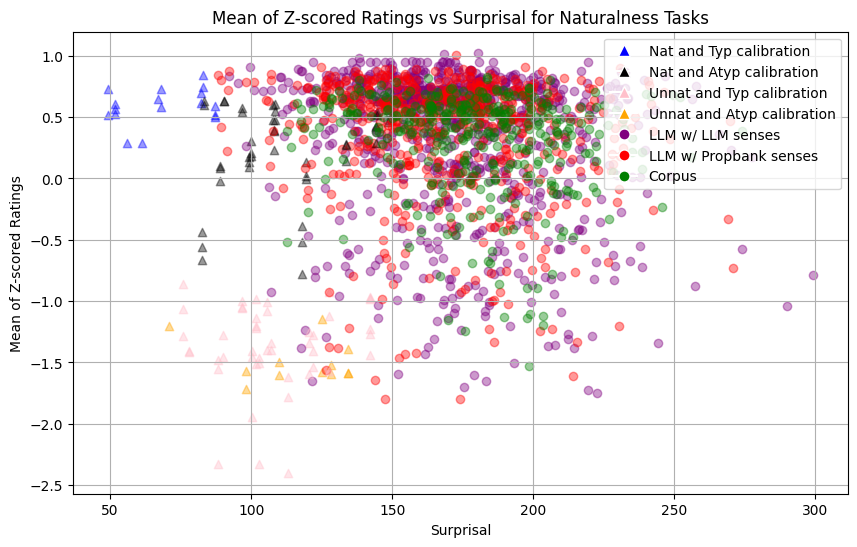

In [218]:
import matplotlib.pyplot as plt

all_data = pd.concat([
    mean_nat_llama_llamasense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_nat_llama_propbanksense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_nat_reddit_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
], keys=['llamasense', 'propbanksense', 'reddit'])  # Adding keys to identify the sources

# Plotting
plt.figure(figsize=(10, 6))

# nat and typ, different colored triangles
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_nat_typ')
# nat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='llamasense_filler_nat_atyp')
# unnat and typ
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='llamasense_filler_unnat_typ')

# unnat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='llamasense_filler_unnat_atyp')

# target
plt.scatter(all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='purple', marker='o', alpha=0.4, label='llamasense_target')

# Plot 'propbanksense' data with red
# nat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='propbanksense_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='propbanksense_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='propbanksense_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='red', marker='o', alpha=0.4, label='propbanksense_target')

# Plot 'reddit' data with green
# nat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='reddit_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='reddit_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='reddit_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Surprisal'],
            all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='green', marker='o', alpha=0.4, label='reddit_target')

color_legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', label='Nat and Typ calibration', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Nat and Atyp calibration', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Typ calibration', markerfacecolor='pink', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Atyp calibration', markerfacecolor='orange', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ LLM senses', markerfacecolor='purple', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ Propbank senses', markerfacecolor='red', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='calibration', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Corpus', markerfacecolor='green', markersize=8)
]
plt.legend(handles=color_legend_elements, loc='upper right')

plt.xlabel('Surprisal')
plt.ylabel('Mean of Z-scored Ratings')
plt.title('Mean of Z-scored Ratings vs Surprisal for Naturalness Tasks')
plt.grid(True)
plt.show()


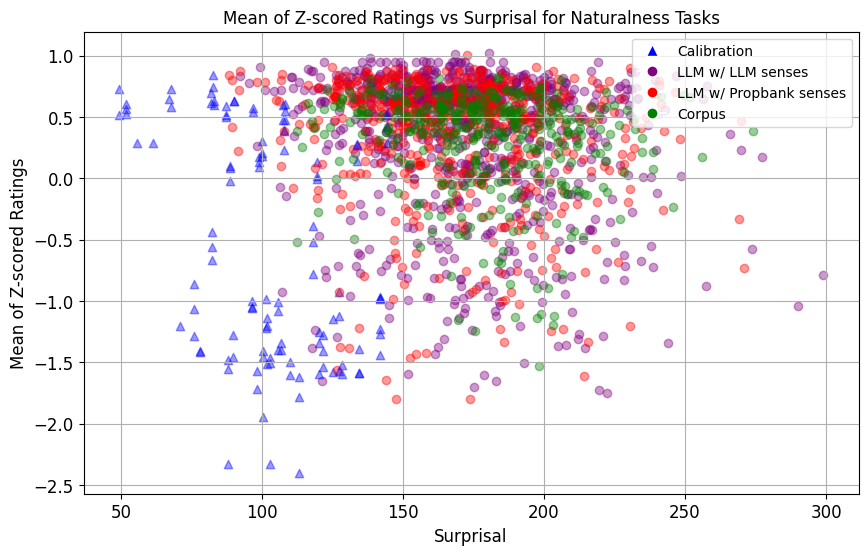

In [219]:
import matplotlib.pyplot as plt

all_data = pd.concat([
    mean_nat_llama_llamasense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_nat_llama_propbanksense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_nat_reddit_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
], keys=['llamasense', 'propbanksense', 'reddit'])  # Adding keys to identify the sources

# Plotting
plt.figure(figsize=(10, 6))

# nat and typ, different colored triangles
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_nat_typ')
# nat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_nat_atyp')
# unnat and typ
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_unnat_typ')

# unnat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_unnat_atyp')

# target
plt.scatter(all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='purple', marker='o', alpha=0.4, label='llamasense_target')

# Plot 'propbanksense' data with red
# nat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='red', marker='o', alpha=0.4, label='propbanksense_target')

# Plot 'reddit' data with green
# nat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Surprisal'],
            all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='green', marker='o', alpha=0.4, label='reddit_target')

color_legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', label='Calibration', markerfacecolor='blue', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='Nat and Atyp calibration', markerfacecolor='black', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Typ calibration', markerfacecolor='pink', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Atyp calibration', markerfacecolor='orange', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ LLM senses', markerfacecolor='purple', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ Propbank senses', markerfacecolor='red', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='calibration', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Corpus', markerfacecolor='green', markersize=8)
]
plt.legend(handles=color_legend_elements, loc='upper right')

plt.xlabel('Surprisal', fontsize='large')
plt.ylabel('Mean of Z-scored Ratings', fontsize='large')
plt.title('Mean of Z-scored Ratings vs Surprisal for Naturalness Tasks', fontsize='large')

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.grid(True)
plt.show()


Plot typicality tasks

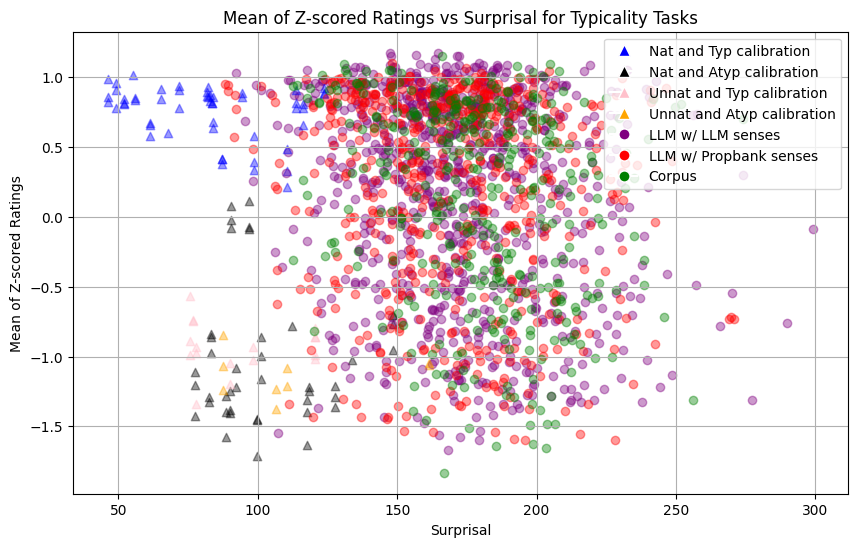

In [220]:
import matplotlib.pyplot as plt
import math

all_data = pd.concat([
    mean_typ_llama_llamasense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_typ_llama_propbanksense_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
    mean_typ_reddit_df[['Sentence', 'Mean of Z-scored Ratings', 'Surprisal', 'Type', 'Naturalness', 'Typicality']],
], keys=['llamasense', 'propbanksense', 'reddit'])  # Adding keys to identify the sources

# Plotting
plt.figure(figsize=(10, 6))

# Plot 'llamasense' data with blue
# nat and typ, different colored triangles
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='llamasense_filler_nat_typ')
# nat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Natural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='llamasense_filler_nat_atyp')
# unnat and typ
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='llamasense_filler_unnat_typ')

# unnat and atyp
plt.scatter(all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('llamasense').loc[(all_data.xs('llamasense')['Type'] == 'filler')
                      & (all_data.xs('llamasense')['Naturalness'] == 'Unnatural')
                      & (all_data.xs('llamasense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='llamasense_filler_unnat_atyp')

# target
plt.scatter(all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('llamasense').loc[all_data.xs('llamasense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='purple', marker='o', alpha=0.4, label='llamasense_target')

# Plot 'propbanksense' data with red
# nat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='propbanksense_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Natural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='propbanksense_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='propbanksense_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('propbanksense').loc[(all_data.xs('propbanksense')['Type'] == 'filler')
                  & (all_data.xs('propbanksense')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('propbanksense')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='propbanksense_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Surprisal'],
            all_data.xs('propbanksense').loc[all_data.xs('propbanksense')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='red', marker='o', alpha=0.4, label='propbanksense_target')

# Plot 'reddit' data with green
# nat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='blue', marker='^', alpha=0.4, label='reddit_filler_nat_typ')

# nat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Natural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='black', marker='^', alpha=0.4, label='reddit_filler_nat_atyp')

# Unnat and typ
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Typical'), 'Mean of Z-scored Ratings'],
            color='pink', marker='^', alpha=0.4, label='reddit_filler_unnat_typ')

# Unnat and atyp
plt.scatter(all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Surprisal'],
            all_data.xs('reddit').loc[(all_data.xs('reddit')['Type'] == 'filler')
                  & (all_data.xs('reddit')['Naturalness'] == 'Unnatural')
                  & (all_data.xs('reddit')['Typicality'] == 'Atypical'), 'Mean of Z-scored Ratings'],
            color='orange', marker='^', alpha=0.4, label='reddit_filler_unnat_atyp')

#target
plt.scatter(all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Surprisal'],
            all_data.xs('reddit').loc[all_data.xs('reddit')['Type'] == 'target', 'Mean of Z-scored Ratings'],
            color='green', marker='o', alpha=0.4, label='reddit_target')

color_legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', label='Nat and Typ calibration', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Nat and Atyp calibration', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Typ calibration', markerfacecolor='pink', markersize=8),
    plt.Line2D([0], [0], marker='^', color='w', label='Unnat and Atyp calibration', markerfacecolor='orange', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ LLM senses', markerfacecolor='purple', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='LLM w/ Propbank senses', markerfacecolor='red', markersize=8),
    # plt.Line2D([0], [0], marker='^', color='w', label='calibration', markerfacecolor='black', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Corpus', markerfacecolor='green', markersize=8)
]
plt.legend(handles=color_legend_elements, loc='upper right')

plt.xlabel('Surprisal')
plt.ylabel('Mean of Z-scored Ratings')
plt.title('Mean of Z-scored Ratings vs Surprisal for Typicality Tasks')
plt.grid(True)
plt.show()


Bar plot for naturalness

In [221]:
longform_nat_llama_llamasense_df = pd.read_csv("naturalness_llama_llamasenses_longform.csv")
longform_typ_llama_llamasense_df = pd.read_csv("typicality_llama_llamasenses_longform.csv")
longform_nat_llama_propbanksense_df = pd.read_csv("naturalness_llama_propbanksenses_longform.csv")
longform_typ_llama_propbanksense_df = pd.read_csv("typicality_llama_propbanksenses_longform.csv")
longform_nat_reddit_df = pd.read_csv("naturalness_reddit_longform.csv")
longform_typ_reddit_df = pd.read_csv("typicality_reddit_longform.csv")

In [222]:
longform_nat_llama_llamasense_df['Generation'] = "llamasense"
longform_nat_llama_propbanksense_df['Generation'] = 'propbanksense'
longform_nat_reddit_df['Generation'] = 'reddit'

all_data_no_keys = pd.concat([
    longform_nat_llama_llamasense_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
    longform_nat_llama_propbanksense_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
    longform_nat_reddit_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
])

# all_data_no_keys

In [223]:
all_data_no_keys['Type'] = all_data_no_keys['Sentence_id'].apply(lambda x: 'filler' if x == 'filler' else 'target')
all_data_no_keys[:3]

,Sentence,Rating,Surprisal,Sentence_id,Naturalness,Typicality,Generation,Type
0,The baby arranged the something.,65.0,127.474388,filler,Unnatural,Typical,llamasense,filler
1,The baby arranged the something.,0.0,127.474388,filler,Unnatural,Typical,llamasense,filler
2,The baby arranged the something.,100.0,127.474388,filler,Unnatural,Typical,llamasense,filler


In [224]:
import random

def bootstrap(data, num_samples, sample_size):
    """
    Arguments:
    - data: The original list of data.
    - num_samples: The number of bootstrap samples to generate.
    - sample_size: The size of each bootstrap sample, which for me is the length of "data".
    Returns:
    - A list of bootstrap samples.
    """
    bootstrap_samples = []
    n = len(data)
    for _ in range(num_samples):
        sample = [random.choice(data) for _ in range(sample_size)]
        bootstrap_samples.append(sample)

    return bootstrap_samples

def calculate_proportion(data):
    """
    Calculates the proportion of 1s in a list of 1s and 0s.
    Arguments:
    - data: The list of 1s and 0s.
    Returns:
    - The proportion of 1s as a float.
    """
    total = len(data)
    count_ones = sum(data)
    proportion = count_ones / total
    return proportion

In [225]:
longform_nat_llama_llamasense_df[:2]

,Unnamed: 0,Rater ID,Sentence,Rating,Sense_id,Sense,Verb,Typicality,Naturalness,Surprisal,Sentence_id,coca_freq,Generation
0,0,1,The baby arranged the something.,65.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108,llamasense
1,1,2,The baby arranged the something.,0.0,filler,filler,arrange,Typical,Unnatural,127.474388,filler,29108,llamasense


In [226]:
def collect_ratings(values):
    return list(values)

subset_nat_llama_llamasense_df = longform_nat_llama_llamasense_df[longform_nat_llama_llamasense_df['Sentence_id'] != "filler"]
rating_list_nat_llamasense = list(subset_nat_llama_llamasense_df['Rating'])

subset_nat_llama_propbanksense_df = longform_nat_llama_propbanksense_df[longform_nat_llama_propbanksense_df['Sentence_id'] != "filler"]
rating_list_nat_propbanksense = list(subset_nat_llama_propbanksense_df['Rating'])

subset_nat_reddit_df = longform_nat_reddit_df[longform_nat_reddit_df['Sentence_id'] != 'filler']
rating_list_nat_reddit = list(subset_nat_reddit_df['Rating'])

subset_nat_typ_nat_df_from_llamasense = longform_nat_llama_llamasense_df[
    (longform_nat_llama_llamasense_df['Naturalness'] != "Natural") &
    (longform_nat_llama_llamasense_df['Typicality'] != "Typical")
]
subset_nat_typ_nat_df_from_propbanksense = longform_nat_llama_propbanksense_df[
    (longform_nat_llama_propbanksense_df['Naturalness'] != "Natural") &
    (longform_nat_llama_propbanksense_df['Typicality'] != "Typical")
]
subset_nat_typ_nat_df_from_reddit = longform_nat_reddit_df[
    (longform_nat_reddit_df['Naturalness'] != "Natural") &
    (longform_nat_reddit_df['Typicality'] != "Typical")
]
rating_list_nat_filler_typ_nat = list(subset_nat_typ_nat_df_from_llamasense['Rating']) + list(subset_nat_typ_nat_df_from_propbanksense['Rating']) + list(subset_nat_typ_nat_df_from_reddit['Rating'])

subset_nat_atyp_nat_df_from_llamasense = longform_nat_llama_llamasense_df[
    (longform_nat_llama_llamasense_df['Naturalness'] != "Natural") &
    (longform_nat_llama_llamasense_df['Typicality'] != "Atypical")
]
subset_nat_atyp_nat_df_from_propbanksense = longform_nat_llama_propbanksense_df[
    (longform_nat_llama_propbanksense_df['Naturalness'] != "Natural") &
    (longform_nat_llama_propbanksense_df['Typicality'] != "Atypical")
]
subset_nat_atyp_nat_df_from_reddit = longform_nat_reddit_df[
    (longform_nat_reddit_df['Naturalness'] != "Natural") &
    (longform_nat_reddit_df['Typicality'] != "Atypical")
]
rating_list_nat_filler_atyp_nat = list(subset_nat_atyp_nat_df_from_llamasense['Rating']) + list(subset_nat_atyp_nat_df_from_propbanksense['Rating']) + list(subset_nat_atyp_nat_df_from_reddit['Rating'])

subset_nat_typ_unnat_df_from_llamasense = longform_nat_llama_llamasense_df[
    (longform_nat_llama_llamasense_df['Naturalness'] != "Unnatural") &
    (longform_nat_llama_llamasense_df['Typicality'] != "Typical")
]
subset_nat_typ_unnat_df_from_propbanksense = longform_nat_llama_propbanksense_df[
    (longform_nat_llama_propbanksense_df['Naturalness'] != "Unnatural") &
    (longform_nat_llama_propbanksense_df['Typicality'] != "Typical")
]
subset_nat_typ_unnat_df_from_reddit = longform_nat_reddit_df[
    (longform_nat_reddit_df['Naturalness'] != "Unnatural") &
    (longform_nat_reddit_df['Typicality'] != "Typical")
]
rating_list_nat_filler_typ_unnat = list(subset_nat_typ_unnat_df_from_llamasense['Rating']) + list(subset_nat_typ_unnat_df_from_propbanksense['Rating']) + list(subset_nat_typ_unnat_df_from_reddit['Rating'])

subset_nat_atyp_unnat_df_from_llamasense = longform_nat_llama_llamasense_df[
    (longform_nat_llama_llamasense_df['Naturalness'] != "Unnatural") &
    (longform_nat_llama_llamasense_df['Typicality'] != "Atypical")
]
subset_nat_atyp_unnat_df_from_propbanksense = longform_nat_llama_propbanksense_df[
    (longform_nat_llama_propbanksense_df['Naturalness'] != "Unnatural") &
    (longform_nat_llama_propbanksense_df['Typicality'] != "Atypical")
]
subset_nat_atyp_unnat_df_from_reddit = longform_nat_reddit_df[
    (longform_nat_reddit_df['Naturalness'] != "Unnatural") &
    (longform_nat_reddit_df['Typicality'] != "Atypical")
]
rating_list_nat_filler_atyp_unnat = list(subset_nat_atyp_unnat_df_from_llamasense['Rating']) + list(subset_nat_atyp_unnat_df_from_propbanksense['Rating']) + list(subset_nat_atyp_unnat_df_from_reddit['Rating'])


bootstrapped_samples_nat = {}
bootstrapped_samples_nat['llamasense'] = bootstrap(rating_list_nat_llamasense,
                                                   1000, len(rating_list_nat_llamasense))
bootstrapped_samples_nat['propbanksense'] = bootstrap(rating_list_nat_propbanksense,
                                                      1000, len(rating_list_nat_propbanksense))
bootstrapped_samples_nat['reddit'] = bootstrap(rating_list_nat_reddit,
                                                1000, len(rating_list_nat_reddit))
bootstrapped_samples_nat['nat_typ_filler'] = bootstrap(rating_list_nat_filler_typ_nat,
                                                1000, len(rating_list_nat_filler_typ_nat))
bootstrapped_samples_nat['nat_atyp_filler'] = bootstrap(rating_list_nat_filler_atyp_nat,
                                                1000, len(rating_list_nat_filler_atyp_nat))
bootstrapped_samples_nat['unnat_typ_filler'] = bootstrap(rating_list_nat_filler_typ_unnat,
                                                1000, len(rating_list_nat_filler_typ_unnat))
bootstrapped_samples_nat['unnat_atyp_filler'] = bootstrap(rating_list_nat_filler_atyp_unnat,
                                                1000, len(rating_list_nat_filler_atyp_unnat))

proportion_bootstrapped_samples_nat = {}
for key, value in bootstrapped_samples_nat.items():
    proportions = []
    for lst in value:
        proportion = calculate_proportion(lst)
        proportions.append(proportion)
    sorted_proportions = sorted(proportions)
    proportion_bootstrapped_samples_nat[key] = sorted_proportions

nat_cis = {}
for key, values in proportion_bootstrapped_samples_nat.items():
    lower_bound = np.percentile(values, 2.5)
    upper_bound = np.percentile(values, 97.5)
    nat_cis[key] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

nat_cis

{'llamasense': {'lower_bound': 79.48629361123697,
  'upper_bound': 81.29986406887177},
 'propbanksense': {'lower_bound': 82.52893728717366,
  'upper_bound': 84.30321367763905},
 'reddit': {'lower_bound': 86.02321428571429, 'upper_bound': 87.7916294642857},
 'nat_typ_filler': {'lower_bound': 80.04451908861641,
  'upper_bound': 81.12920036524915},
 'nat_atyp_filler': {'lower_bound': 69.82046851547423,
  'upper_bound': 71.0792813237081},
 'unnat_typ_filler': {'lower_bound': 81.91515470656594,
  'upper_bound': 82.93872203660662},
 'unnat_atyp_filler': {'lower_bound': 83.13101994521486,
  'upper_bound': 84.14390301318268}}

In [227]:
all_data_no_keys[:3]

,Sentence,Rating,Surprisal,Sentence_id,Naturalness,Typicality,Generation,Type
0,The baby arranged the something.,65.0,127.474388,filler,Unnatural,Typical,llamasense,filler
1,The baby arranged the something.,0.0,127.474388,filler,Unnatural,Typical,llamasense,filler
2,The baby arranged the something.,100.0,127.474388,filler,Unnatural,Typical,llamasense,filler


<Figure size 1000x600 with 0 Axes>

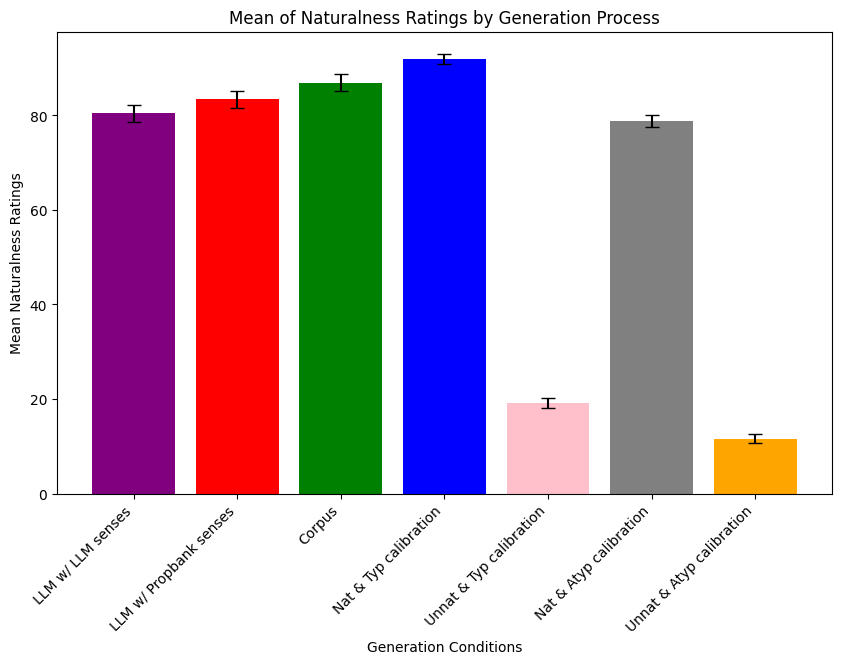

In [228]:
grouped_data = all_data_no_keys.groupby(['Type', 'Naturalness', 'Typicality', 'Generation'])['Rating'].mean().reset_index()

# Create bar chart
plt.figure(figsize=(10, 6))

# Extracting the means for each condition
means = [
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'llamasense')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'propbanksense')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'reddit')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Naturalness'] == 'Natural') & (grouped_data['Typicality'] == 'Typical')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Naturalness'] == 'Unnatural') & (grouped_data['Typicality'] == 'Typical')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Typicality'] == 'Atypical') & (grouped_data['Naturalness'] == 'Natural')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Typicality'] == 'Atypical') & (grouped_data['Naturalness'] == 'Unnatural')]['Rating'].values[0]
]

conf_intervals_nat = [
    nat_cis['llamasense']['upper_bound'] - nat_cis['llamasense']['lower_bound'],
    nat_cis['propbanksense']['upper_bound'] - nat_cis['propbanksense']['lower_bound'],
    nat_cis['reddit']['upper_bound'] - nat_cis['reddit']['lower_bound'],
    nat_cis['nat_typ_filler']['upper_bound'] - nat_cis['nat_typ_filler']['lower_bound'],
    nat_cis['unnat_typ_filler']['upper_bound'] - nat_cis['unnat_typ_filler']['lower_bound'],
    nat_cis['nat_atyp_filler']['upper_bound'] - nat_cis['nat_atyp_filler']['lower_bound'],
    nat_cis['unnat_atyp_filler']['upper_bound'] - nat_cis['unnat_atyp_filler']['lower_bound']
]

plt.figure(figsize=(10, 6))

x = range(len(means))
plt.bar(x, means, yerr=conf_intervals_nat, capsize=5, color=['purple', 'red', 'green', 'blue', 'pink', 'grey', 'orange'])

labels = ['LLM w/ LLM senses', 'LLM w/ Propbank senses', 'Corpus', 'Nat & Typ calibration',
          'Unnat & Typ calibration', 'Nat & Atyp calibration', 'Unnat & Atyp calibration']
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel('Generation Conditions')
plt.ylabel('Mean Naturalness Ratings')
plt.title('Mean of Naturalness Ratings by Generation Process')

plt.show()

In [229]:
import seaborn as sns

<ipython-input-230-9639ce6b76ad>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=labels, y=means, palette=colors, ci=None)
<ipython-input-230-9639ce6b76ad>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=means, palette=colors, ci=None)


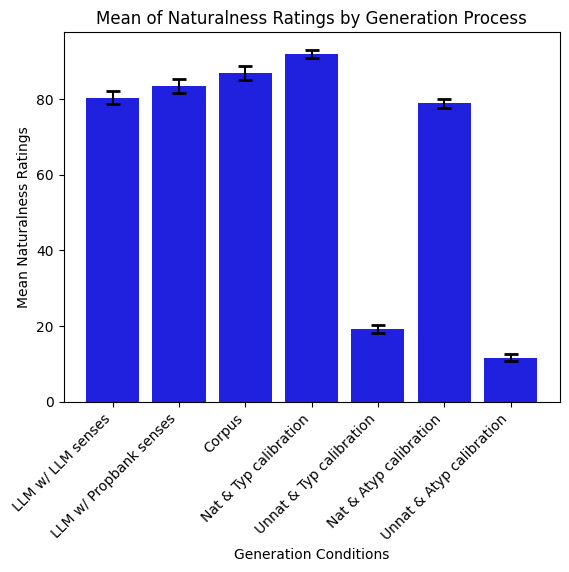

In [230]:
# Define the order of x-axis labels
labels = ['LLM w/ LLM senses', 'LLM w/ Propbank senses', 'Corpus', 'Nat & Typ calibration',
          'Unnat & Typ calibration', 'Nat & Atyp calibration', 'Unnat & Atyp calibration']

# Define the colors
colors = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

# Create the bar plot using seaborn


sns.barplot(x=labels, y=means, palette=colors, ci=None)
for i, err in enumerate(conf_intervals_nat):
    plt.errorbar(x=i, y=means[i], yerr=err, fmt='none', ecolor='black', capsize=5, capthick=2)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Generation Conditions')
plt.ylabel('Mean Naturalness Ratings')
plt.title('Mean of Naturalness Ratings by Generation Process')

plt.show()

In [231]:
longform_typ_llama_llamasense_df['Generation'] = "llamasense"
longform_typ_llama_propbanksense_df['Generation'] = 'propbanksense'
longform_typ_reddit_df['Generation'] = 'reddit'

all_data_no_keys = pd.concat([
    longform_typ_llama_llamasense_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
    longform_typ_llama_propbanksense_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
    longform_typ_reddit_df[['Sentence', 'Rating', 'Surprisal', 'Sentence_id', 'Naturalness', 'Typicality', 'Generation']],
])

all_data_no_keys['Type'] = all_data_no_keys['Sentence_id'].apply(lambda x: 'filler' if x == 'filler' else 'target')


In [232]:
subset_typ_llama_llamasense_df = longform_typ_llama_llamasense_df[longform_typ_llama_llamasense_df['Sentence_id'] != "filler"]
rating_list_typ_llamasense = list(subset_typ_llama_llamasense_df['Rating'])

subset_typ_llama_propbanksense_df = longform_typ_llama_propbanksense_df[longform_typ_llama_propbanksense_df['Sentence_id'] != "filler"]
rating_list_typ_propbanksense = list(subset_typ_llama_propbanksense_df['Rating'])

subset_typ_reddit_df = longform_typ_reddit_df[longform_typ_reddit_df['Sentence_id'] != 'filler']
rating_list_typ_reddit = list(subset_typ_reddit_df['Rating'])

subset_typ_typ_nat_df_from_llamasense = longform_typ_llama_llamasense_df[
    (longform_typ_llama_llamasense_df['Naturalness'] != "Natural") &
    (longform_typ_llama_llamasense_df['Typicality'] != "Typical")
]
subset_typ_typ_nat_df_from_propbanksense = longform_typ_llama_propbanksense_df[
    (longform_typ_llama_propbanksense_df['Naturalness'] != "Natural") &
    (longform_typ_llama_propbanksense_df['Typicality'] != "Typical")
]
subset_typ_typ_nat_df_from_reddit = longform_typ_reddit_df[
    (longform_typ_reddit_df['Naturalness'] != "Natural") &
    (longform_typ_reddit_df['Typicality'] != "Typical")
]
rating_list_typ_filler_typ_nat = list(subset_typ_typ_nat_df_from_llamasense['Rating']) + list(subset_typ_typ_nat_df_from_propbanksense['Rating']) + list(subset_typ_typ_nat_df_from_reddit['Rating'])

subset_typ_atyp_nat_df_from_llamasense = longform_typ_llama_llamasense_df[
    (longform_typ_llama_llamasense_df['Naturalness'] != "Natural") &
    (longform_typ_llama_llamasense_df['Typicality'] != "Atypical")
]
subset_typ_atyp_nat_df_from_propbanksense = longform_typ_llama_propbanksense_df[
    (longform_typ_llama_propbanksense_df['Naturalness'] != "Natural") &
    (longform_typ_llama_propbanksense_df['Typicality'] != "Atypical")
]
subset_typ_atyp_nat_df_from_reddit = longform_typ_reddit_df[
    (longform_typ_reddit_df['Naturalness'] != "Natural") &
    (longform_typ_reddit_df['Typicality'] != "Atypical")
]
rating_list_typ_filler_atyp_nat = list(subset_typ_atyp_nat_df_from_llamasense['Rating']) + list(subset_typ_atyp_nat_df_from_propbanksense['Rating']) + list(subset_typ_atyp_nat_df_from_reddit['Rating'])

subset_typ_typ_unnat_df_from_llamasense = longform_typ_llama_llamasense_df[
    (longform_typ_llama_llamasense_df['Naturalness'] != "Unnatural") &
    (longform_typ_llama_llamasense_df['Typicality'] != "Typical")
]
subset_typ_typ_unnat_df_from_propbanksense = longform_typ_llama_propbanksense_df[
    (longform_typ_llama_propbanksense_df['Naturalness'] != "Unnatural") &
    (longform_typ_llama_propbanksense_df['Typicality'] != "Typical")
]
subset_typ_typ_unnat_df_from_reddit = longform_typ_reddit_df[
    (longform_typ_reddit_df['Naturalness'] != "Unnatural") &
    (longform_typ_reddit_df['Typicality'] != "Typical")
]
rating_list_typ_filler_typ_unnat = list(subset_typ_typ_unnat_df_from_llamasense['Rating']) + list(subset_typ_typ_unnat_df_from_propbanksense['Rating']) + list(subset_typ_typ_unnat_df_from_reddit['Rating'])

subset_typ_atyp_unnat_df_from_llamasense = longform_typ_llama_llamasense_df[
    (longform_typ_llama_llamasense_df['Naturalness'] != "Unnatural") &
    (longform_typ_llama_llamasense_df['Typicality'] != "Atypical")
]
subset_typ_atyp_unnat_df_from_propbanksense = longform_typ_llama_propbanksense_df[
    (longform_typ_llama_propbanksense_df['Naturalness'] != "Unnatural") &
    (longform_typ_llama_propbanksense_df['Typicality'] != "Atypical")
]
subset_typ_atyp_unnat_df_from_reddit = longform_typ_reddit_df[
    (longform_typ_reddit_df['Naturalness'] != "Unnatural") &
    (longform_typ_reddit_df['Typicality'] != "Atypical")
]
rating_list_typ_filler_atyp_unnat = list(subset_typ_atyp_unnat_df_from_llamasense['Rating']) + list(subset_typ_atyp_unnat_df_from_propbanksense['Rating']) + list(subset_typ_atyp_unnat_df_from_reddit['Rating'])


bootstrapped_samples_typ = {}
bootstrapped_samples_typ['llamasense'] = bootstrap(rating_list_typ_llamasense,
                                                   1000, len(rating_list_typ_llamasense))
bootstrapped_samples_typ['propbanksense'] = bootstrap(rating_list_typ_propbanksense,
                                                      1000, len(rating_list_typ_propbanksense))
bootstrapped_samples_typ['reddit'] = bootstrap(rating_list_typ_reddit,
                                                1000, len(rating_list_typ_reddit))
bootstrapped_samples_typ['nat_typ_filler'] = bootstrap(rating_list_typ_filler_typ_nat,
                                                1000, len(rating_list_typ_filler_typ_nat))
bootstrapped_samples_typ['nat_atyp_filler'] = bootstrap(rating_list_typ_filler_atyp_nat,
                                                1000, len(rating_list_typ_filler_atyp_nat))
bootstrapped_samples_typ['unnat_typ_filler'] = bootstrap(rating_list_typ_filler_typ_unnat,
                                                1000, len(rating_list_typ_filler_typ_unnat))
bootstrapped_samples_typ['unnat_atyp_filler'] = bootstrap(rating_list_typ_filler_atyp_unnat,
                                                1000, len(rating_list_typ_filler_atyp_unnat))

proportion_bootstrapped_samples_typ = {}
for key, value in bootstrapped_samples_typ.items():
    proportions = []
    for lst in value:
        proportion = calculate_proportion(lst)
        proportions.append(proportion)
    sorted_proportions = sorted(proportions)
    proportion_bootstrapped_samples_typ[key] = sorted_proportions

typ_cis = {}
for key, values in proportion_bootstrapped_samples_typ.items():
    lower_bound = np.percentile(values, 2.5)
    upper_bound = np.percentile(values, 97.5)
    typ_cis[key] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

typ_cis

{'llamasense': {'lower_bound': 63.07604237480172,
  'upper_bound': 65.22836505778382},
 'propbanksense': {'lower_bound': 66.42960260115608,
  'upper_bound': 68.9105563583815},
 'reddit': {'lower_bound': 64.57389295954125,
  'upper_bound': 67.06754539662313},
 'nat_typ_filler': {'lower_bound': 62.572311711867336,
  'upper_bound': 63.91463983416825},
 'nat_atyp_filler': {'lower_bound': 61.76084893777815,
  'upper_bound': 63.23370350155344},
 'unnat_typ_filler': {'lower_bound': 57.06657005011594,
  'upper_bound': 58.44671067394719},
 'unnat_atyp_filler': {'lower_bound': 69.69525023504737,
  'upper_bound': 70.86707890359442}}

<Figure size 1000x600 with 0 Axes>

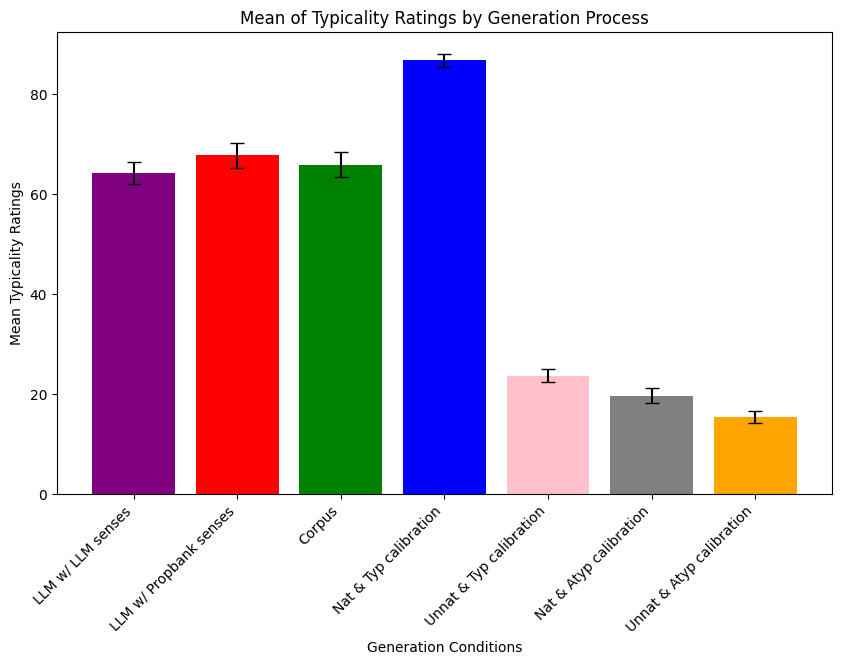

In [233]:
grouped_data = all_data_no_keys.groupby(['Type', 'Naturalness', 'Typicality', 'Generation'])['Rating'].mean().reset_index()
# grouped_data = all_data_no_keys.groupby(['Type', 'Naturalness', 'Typicality', 'Generation'])['Mean of Z-scored Ratings'].agg(['mean', 'std']).reset_index()

# Create bar chart
plt.figure(figsize=(10, 6))

# Extracting the means for each condition
means = [
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'llamasense')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'propbanksense')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'target') & (grouped_data['Generation'] == 'reddit')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Naturalness'] == 'Natural') & (grouped_data['Typicality'] == 'Typical')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Naturalness'] == 'Unnatural') & (grouped_data['Typicality'] == 'Typical')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Typicality'] == 'Atypical') & (grouped_data['Naturalness'] == 'Natural')]['Rating'].values[0],
    grouped_data[(grouped_data['Type'] == 'filler') & (grouped_data['Typicality'] == 'Atypical') & (grouped_data['Naturalness'] == 'Unnatural')]['Rating'].values[0]
]

conf_intervals_typ = [
    typ_cis['llamasense']['upper_bound'] - typ_cis['llamasense']['lower_bound'],
    typ_cis['propbanksense']['upper_bound'] - typ_cis['propbanksense']['lower_bound'],
    typ_cis['reddit']['upper_bound'] - typ_cis['reddit']['lower_bound'],
    typ_cis['nat_typ_filler']['upper_bound'] - typ_cis['nat_typ_filler']['lower_bound'],
    typ_cis['unnat_typ_filler']['upper_bound'] - typ_cis['unnat_typ_filler']['lower_bound'],
    typ_cis['nat_atyp_filler']['upper_bound'] - typ_cis['nat_atyp_filler']['lower_bound'],
    typ_cis['unnat_atyp_filler']['upper_bound'] - typ_cis['unnat_atyp_filler']['lower_bound']
]

# Create bar chart
plt.figure(figsize=(10, 6))

x = range(len(means))
plt.bar(x, means, yerr=conf_intervals_typ, capsize=5, color=['purple', 'red', 'green', 'blue', 'pink', 'grey', 'orange'])

labels = ['LLM w/ LLM senses', 'LLM w/ Propbank senses', 'Corpus', 'Nat & Typ calibration',
          'Unnat & Typ calibration', 'Nat & Atyp calibration', 'Unnat & Atyp calibration']
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel('Generation Conditions')
plt.ylabel('Mean Typicality Ratings')
plt.title('Mean of Typicality Ratings by Generation Process')

plt.show()

# Show plot
# plt.show()

<ipython-input-234-5e449b7792ab>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=labels, y=means, palette=colors, ci=None)
<ipython-input-234-5e449b7792ab>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=means, palette=colors, ci=None)


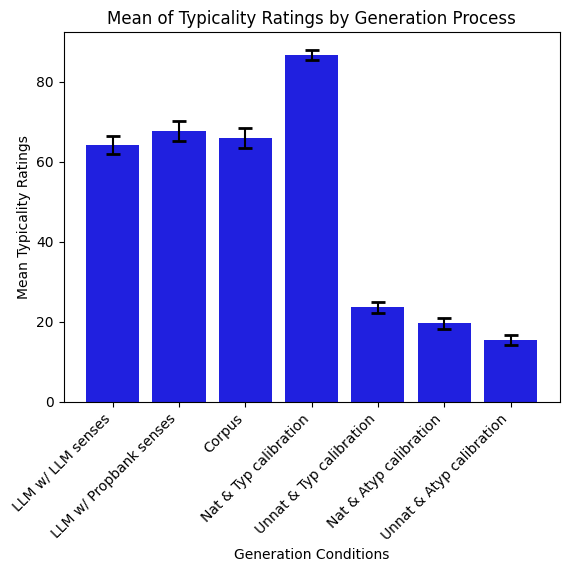

In [234]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Define the order of x-axis labels
labels = ['LLM w/ LLM senses', 'LLM w/ Propbank senses', 'Corpus', 'Nat & Typ calibration',
          'Unnat & Typ calibration', 'Nat & Atyp calibration', 'Unnat & Atyp calibration']

# Define the colors
colors = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

# Create the bar plot using seaborn
# sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=means, palette=colors, ci=None)
for i, err in enumerate(conf_intervals_typ):
    plt.errorbar(x=i, y=means[i], yerr=err, fmt='none', ecolor='black', capsize=5, capthick=2)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Generation Conditions')
plt.ylabel('Mean Typicality Ratings')
plt.title('Mean of Typicality Ratings by Generation Process')

plt.show()


Generate surprisal histogram plot

In [235]:
path_llama_llama = '/content/drive/MyDrive/projects/2023/glass_project/01_19_24/llama_llamasenses_generation_top_four_surp.csv'
path_llama_propbank = '/content/drive/MyDrive/projects/2023/glass_project/01_26_24/llama_propbanksenses_generation_top_four_surp.csv'
path_reddit = '/content/drive/MyDrive/projects/2023/glass_project/02_16_24/reddit_sents_with_originals_surp.csv'

In [236]:
df_llama_llama_surps = pd.read_csv(path_llama_llama)
df_llama_propbank_surps = pd.read_csv(path_llama_propbank)
df_reddit_surps = pd.read_csv(path_reddit)

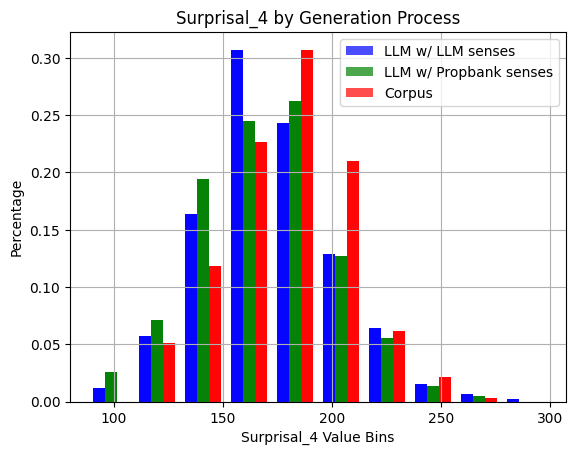

In [237]:
total_counts = [len(df_llama_llama_surps), len(df_llama_propbank_surps), len(df_reddit_surps)]

# Normalize each dataset manually
for i in range(len(total_counts)):
    plt.hist([df_llama_llama_surps['surprisal_4'],
              df_llama_propbank_surps['surprisal_4'],
              df_reddit_surps['surprisal_4']],
             bins=10, color=['blue', 'green', 'red'], alpha=0.7, label=['LLM w/ LLM senses',
                                                                        'LLM w/ Propbank senses',
                                                                        'Corpus'],
             weights=[np.ones_like(df_llama_llama_surps['surprisal_4']) / total_counts[0],
                      np.ones_like(df_llama_propbank_surps['surprisal_4']) / total_counts[1],
                      np.ones_like(df_reddit_surps['surprisal_4']) / total_counts[2]])

plt.xlabel('Surprisal_4 Value Bins')
plt.ylabel('Percentage')
plt.title('Surprisal_4 by Generation Process')
plt.legend(['LLM w/ LLM senses', 'LLM w/ Propbank senses', 'Corpus'])
plt.grid(True)
plt.show()

Concatenate dataframes for brms

In [238]:
nat_longform_llama_llamasenses_df = pd.read_csv('naturalness_llama_llamasenses_longform.csv')
nat_longform_llama_propbanksenses_df = pd.read_csv('naturalness_llama_propbanksenses_longform.csv')
nat_longform_reddit_df = pd.read_csv('naturalness_reddit_longform.csv')

nat_longform_llama_llamasenses_df['Generation'] = 'llama_llamasenses'
nat_longform_llama_propbanksenses_df['Generation'] = 'llama_propbanksenses'
nat_longform_reddit_df['Generation'] = 'reddit'

nat_longform_llama_llamasenses_df.loc[nat_longform_llama_llamasenses_df['Sense'] == 'filler', 'Generation'] = 'filler'
nat_longform_llama_propbanksenses_df.loc[nat_longform_llama_propbanksenses_df['Sense'] == 'filler', 'Generation'] = 'filler'
nat_longform_reddit_df.loc[nat_longform_reddit_df['Sense'] == 'filler', 'Generation'] = 'filler'

nat_longform_llama_llamasenses_df['Rater ID'] = nat_longform_llama_llamasenses_df['Rater ID'].astype(str) + '_llamasenses'
nat_longform_llama_propbanksenses_df['Rater ID'] = nat_longform_llama_propbanksenses_df['Rater ID'].astype(str) + '_propbanksenses'
nat_longform_reddit_df['Rater ID'] = nat_longform_reddit_df['Rater ID'].astype(str) + '_reddit'

nat_longform_brms = pd.concat([nat_longform_llama_llamasenses_df,
                             nat_longform_llama_propbanksenses_df,
                             nat_longform_reddit_df])

nat_longform_brms.to_csv("nat_longform_brms.csv")

In [239]:
typ_longform_llama_llamasenses_df = pd.read_csv('typicality_llama_llamasenses_longform.csv')
typ_longform_llama_propbanksenses_df = pd.read_csv('typicality_llama_propbanksenses_longform.csv')
typ_longform_reddit_df = pd.read_csv('typicality_reddit_longform.csv')

typ_longform_llama_llamasenses_df['Generation'] = 'llama_llamasenses'
typ_longform_llama_propbanksenses_df['Generation'] = 'llama_propbanksenses'
typ_longform_reddit_df['Generation'] = 'reddit'

typ_longform_llama_llamasenses_df.loc[typ_longform_llama_llamasenses_df['Sense'] == 'filler', 'Generation'] = 'filler'
typ_longform_llama_propbanksenses_df.loc[typ_longform_llama_propbanksenses_df['Sense'] == 'filler', 'Generation'] = 'filler'
typ_longform_reddit_df.loc[typ_longform_reddit_df['Sense'] == 'filler', 'Generation'] = 'filler'

typ_longform_llama_llamasenses_df['Rater ID'] = typ_longform_llama_llamasenses_df['Rater ID'].astype(str) + '_llamasenses'
typ_longform_llama_propbanksenses_df['Rater ID'] = typ_longform_llama_propbanksenses_df['Rater ID'].astype(str) + '_propbanksenses'
typ_longform_reddit_df['Rater ID'] = typ_longform_reddit_df['Rater ID'].astype(str) + '_reddit'

typ_longform_brms = pd.concat([typ_longform_llama_llamasenses_df,
                             typ_longform_llama_propbanksenses_df,
                             typ_longform_reddit_df])

typ_longform_brms.to_csv("typ_longform_brms.csv")

Get highest and lowest ratings per generation type per nat/typ

In [244]:
def find_extreme_sentences(dataframe):
    # Find maximum and minimum Mean of Z-scored Ratings
    max_rating = dataframe['Mean of Z-scored Ratings'].max()
    min_rating = dataframe['Mean of Z-scored Ratings'].min()

    # Find all sentences with the maximum and minimum ratings
    max_sentences = dataframe[dataframe['Mean of Z-scored Ratings'] == max_rating]['Sentence'].tolist()
    min_sentences = dataframe[dataframe['Mean of Z-scored Ratings'] == min_rating]['Sentence'].tolist()

    return max_sentences, min_sentences

In [243]:
nat_mean_reddit = pd.read_csv("nat_mean_reddit.csv")
typ_mean_reddit = pd.read_csv("typ_mean_reddit.csv")

nat_mean_reddit_extremes = find_extreme_sentences(nat_mean_reddit)
typ_mean_reddit_extremes = find_extreme_sentences(typ_mean_reddit)

print(nat_mean_reddit_extremes)
print(typ_mean_reddit_extremes)

(['The people knew the truth.'], ['The gardener clipped the was.'])
(['The staff cleaned the tables.'], ['The sign recalled the story.'])


In [245]:
nat_mean_llama_llamasenses = pd.read_csv("nat_mean_llama_llamasenses.csv")
typ_mean_llama_llamasenses = pd.read_csv("typ_mean_llama_llamasenses.csv")

nat_mean_llama_llamasenses_extremes = find_extreme_sentences(nat_mean_llama_llamasenses)
typ_mean_llama_llamasenses_extremes = find_extreme_sentences(typ_mean_llama_llamasenses)

print(nat_mean_llama_llamasenses_extremes)
print(typ_mean_llama_llamasenses_extremes)

(['The police hit the protesters.'], ['The movie drew the entiretyofmyattention.'])
(['The firemen saved the building.', 'The woman understood the idea.'], ['The verb phoned the verb.'])


In [246]:
nat_mean_llama_propbanksenses = pd.read_csv("nat_mean_llama_propbanksenses.csv")
typ_mean_llama_propbanksenses = pd.read_csv("typ_mean_llama_propbanksenses.csv")

nat_mean_llama_propbanksenses_extremes = find_extreme_sentences(nat_mean_llama_propbanksenses)
typ_mean_llama_propbanksenses_extremes = find_extreme_sentences(typ_mean_llama_propbanksenses)

print(nat_mean_llama_propbanksenses_extremes)
print(typ_mean_llama_propbanksenses_extremes)

(['The company fired the employee.'], ['The letter posted the previous.'])
(['The criminal broke the law.'], ['The chicken chopped the onions.', 'The water dropped the bread.'])
